In [11]:
import numpy as np
import matplotlib.pyplot as plt 
import os; os.chdir("..")
from melatonin.simulation import car_exhaust


In [150]:
duration = 10
fs = 44_100
N_mics = 8
N_sources = 3

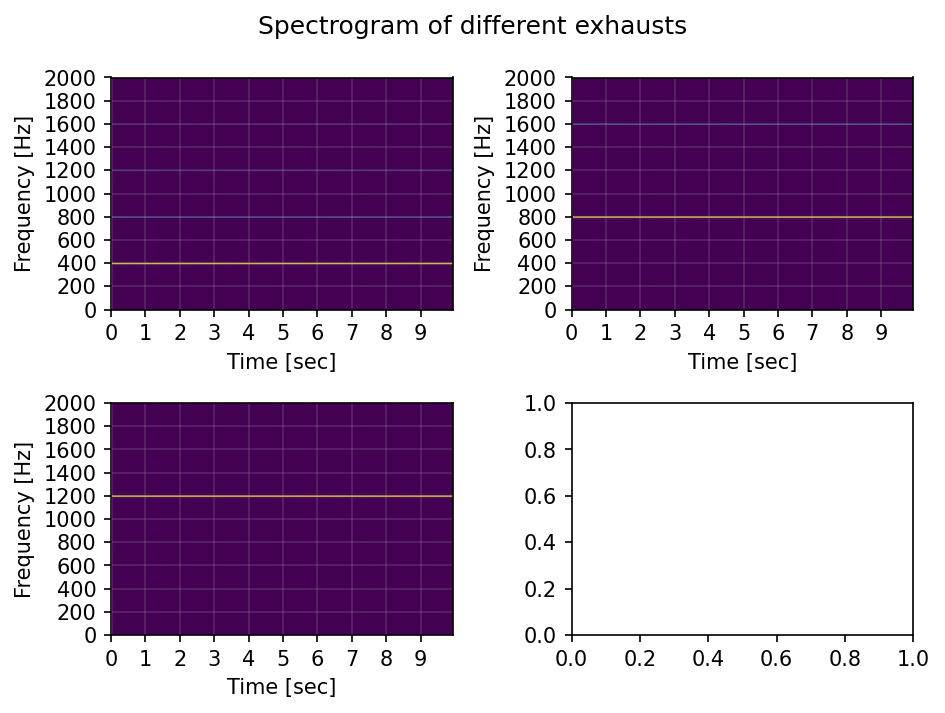

In [151]:
import scipy.signal
t = np.linspace(0, duration, num=int(fs*duration))
different_exhausts = [
    #(np.sin(t*j*400*2*np.pi)).astype(np.float32)
    (scipy.signal.sawtooth(t*j*400*2*np.pi)).astype(np.float32)
    for j in range(1, N_sources+1)
]

fig, axs = plt.subplots(2, 2, dpi=150)
for i, exhaust in enumerate(different_exhausts):
    ax = axs[i//2][i%2]
    f, t, Sxx = scipy.signal.spectrogram(exhaust, fs, nperseg=fs//10)
    ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_ylim(0, 2_000)
    ax.set_yticks(np.linspace(0, 2_000, 11))
    ax.set_xticks(np.arange(0, duration))
    ax.grid(alpha=.2)
    #plt.ylim(0, 500)

plt.suptitle("Spectrogram of different exhausts")
plt.tight_layout() 

    

In [5]:
# different_exhausts = [
#     car_exhaust(
#         frequencies = parameters[0],
#         general_modulation=parameters[1],
#         revving_zone=parameters[2],
#         volume=.9,
#         duration=duration
#     )[1]
#     for parameters in [
#         [np.array([20, 100, 60, 200, 30]), 30, [7, 10]],
#         [np.array([30, 70, 40, 300, 25]), 30, [7, 10]],
#         [np.array([40, 90, 50, 100, 45]), 40, [7, 10]],
#         [np.array([35, 110, 40, 250, 55]), 20, [7, 10]],
#     ]
# ]

Text(0.5, 1.0, 'Positions of elements\nthird dimension ignored (for now)')

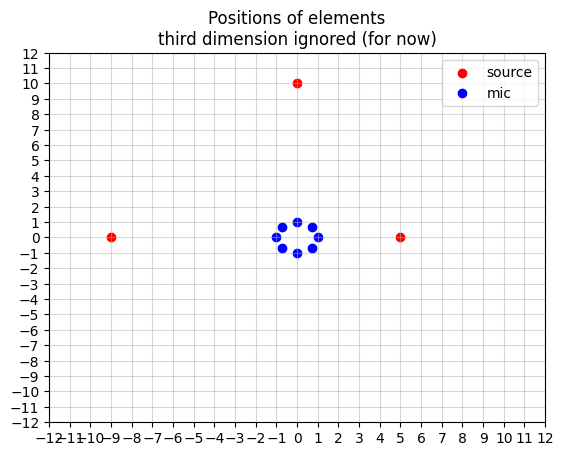

In [152]:


#source_positions = np.random.randn(N_sources, 2)*5
source_positions = np.array([
    [5.0, 0],
    [0, 10.0],
    [-9.0, 0]
])

angle_rotation = np.pi * 2 / N_mics
rotation_matrix = np.array([
    [np.cos(angle_rotation), -np.sin(angle_rotation)],
    [np.sin(angle_rotation), np.cos(angle_rotation)]
])
mic_positions = []
for i in range(N_mics):
    last_position = mic_positions[-1] if mic_positions else np.array([1, 0])
    mic_positions.append(np.matmul(rotation_matrix, last_position))

mic_positions = np.stack(mic_positions)

plt.scatter(
    source_positions[:, 0],
    source_positions[:, 1],
    label="source",
    color="red",
    marker="o"
)

plt.scatter(
    mic_positions[:, 0],
    mic_positions[:, 1],
    label="mic",
    color="blue",
    marker="o"
)
plt.ylim(-12, 12)
plt.xlim(-12, 12)
plt.xticks(np.linspace(-12, 12, 25))
plt.yticks(np.linspace(-12, 12, 25))
plt.legend()
plt.grid(alpha=.5)
plt.title("Positions of elements\nthird dimension ignored (for now)")

In [15]:
speed_of_sound = 343
def generate_mic_signals(mic_positions, source_positions, different_exhausts, noise=True, verbose=True):
    distances = []
    for mic_i in range(mic_positions.shape[0]):
        distances.append(np.linalg.norm((source_positions - mic_positions[mic_i, :]), axis=1))
    #np.concatenate(distances, axis=1)
    distances = np.array(distances)
    
    time_window = 8
    mic_signals = []

    for mic_i in range(len(mic_positions)):
        mic_signal = None
        for source_j in range(len(source_positions)):
            delay = distances[mic_i, source_j]/speed_of_sound
            start = int(fs * delay)
            stop = min(start + int(fs * time_window), int(different_exhausts[0].shape[0]))
            attenuation = 1/(1+np.log(delay+1)) # TODO: CHECK THIS
            delayed_signal = np.zeros(int(time_window * fs))
            delayed_signal[start:] = attenuation * different_exhausts[source_j][:int(time_window*fs-start)]
            if verbose:
                print(f"Delay for source {source_j} to microphone {mic_i} is {delay:.4f}; attn {attenuation:.2f}")
            if mic_signal is None:
                mic_signal = delayed_signal
            else:
                mic_signal += delayed_signal
        if noise:
            # 0.01 noise amplitude against 0.99 signal is ~40dB SNR
            mic_signal += np.random.randn(int(time_window * fs))*0.01
        mic_signals.append(mic_signal)
    return mic_signals


In [154]:
mic_signals = generate_mic_signals(mic_positions, source_positions, different_exhausts, verbose=False)

FFT analysis of microphones

Delay for source 0 to microphone 0 is 0.0127; attn 0.99
Delay for source 1 to microphone 0 is 0.0279; attn 0.97
Delay for source 2 to microphone 0 is 0.0284; attn 0.97
Delay for source 0 to microphone 1 is 0.0149; attn 0.99
Delay for source 1 to microphone 1 is 0.0277; attn 0.97
Delay for source 2 to microphone 1 is 0.0264; attn 0.97
Delay for source 0 to microphone 2 is 0.0168; attn 0.98
Delay for source 1 to microphone 2 is 0.0292; attn 0.97
Delay for source 2 to microphone 2 is 0.0243; attn 0.98
Delay for source 0 to microphone 3 is 0.0175; attn 0.98
Delay for source 1 to microphone 3 is 0.0314; attn 0.97
Delay for source 2 to microphone 3 is 0.0233; attn 0.98
Delay for source 0 to microphone 4 is 0.0168; attn 0.98
Delay for source 1 to microphone 4 is 0.0330; attn 0.97
Delay for source 2 to microphone 4 is 0.0243; attn 0.98
Delay for source 0 to microphone 5 is 0.0149; attn 0.99
Delay for source 1 to microphone 5 is 0.0332; attn 0.97
Delay for source 2 to microphone 5 is 0.0264; at

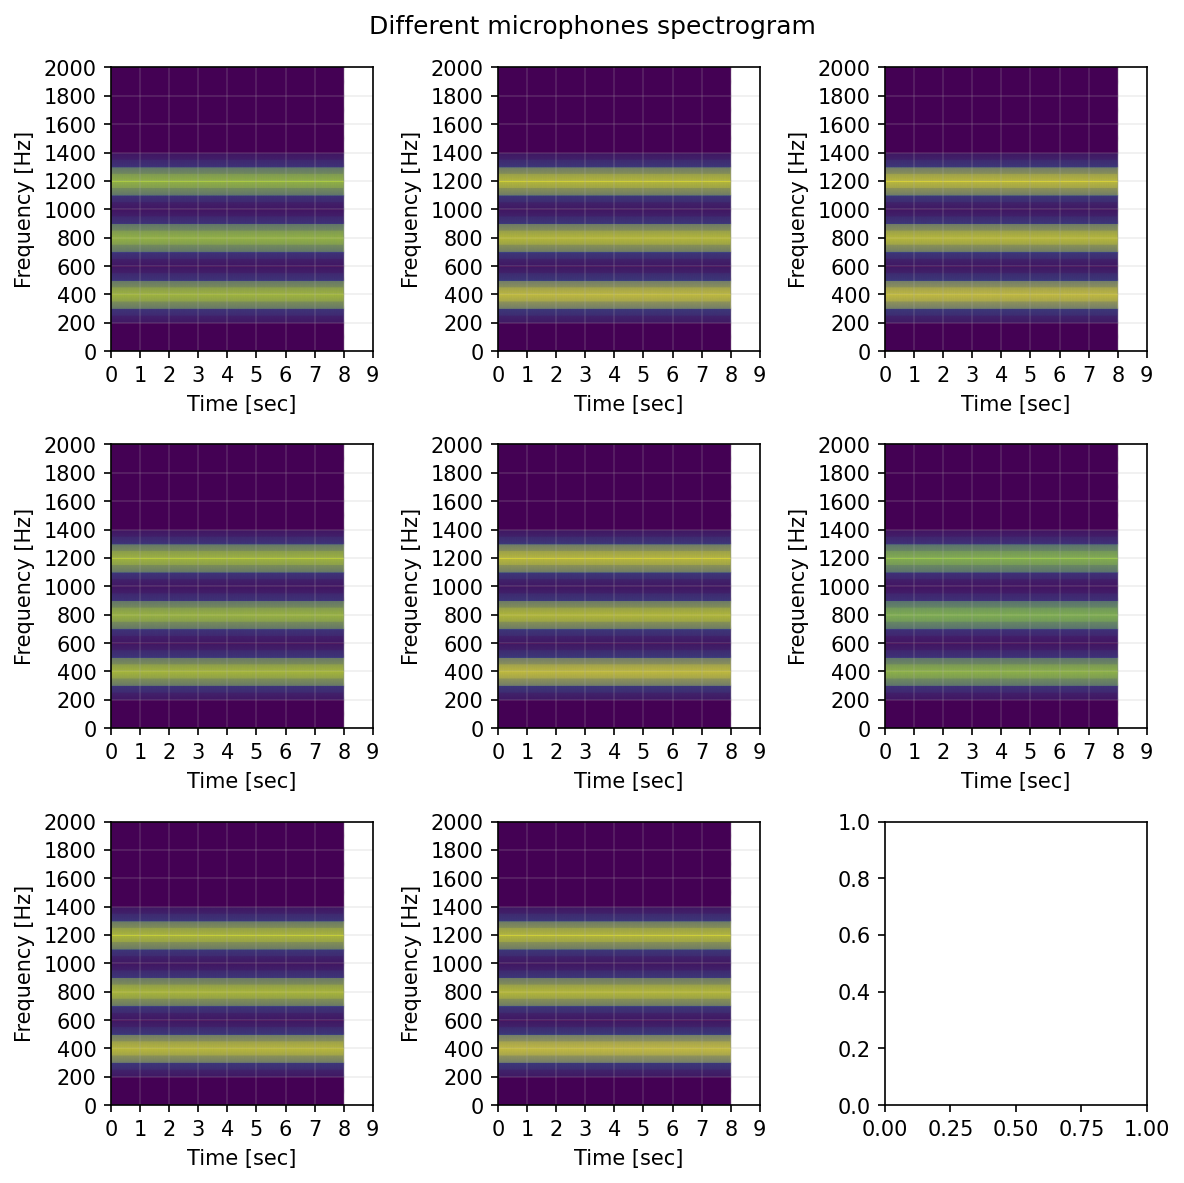

In [16]:


fig, axs = plt.subplots(N_mics//3+1, 3, dpi=150, figsize=(8, 8))
for i, exhaust in enumerate(mic_signals):
    ax = axs[i//3][i%3]
    f, t, Sxx = scipy.signal.spectrogram(exhaust, fs, window=('tukey', 10), noverlap=0, nperseg=fs//100)
    ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_ylim(0, 2_000)
    ax.set_yticks(np.linspace(0, 2_000, 11))
    ax.set_xticks(np.arange(0, duration))
    ax.grid(alpha=.2)
    #plt.ylim(0, 500)

plt.suptitle("Different microphones spectrogram")
plt.tight_layout() 

    

In [17]:
import logging
logging.basicConfig(
    level="INFO"
)

In [18]:
nfft = 2048
def overlapping_slices(
    slice_size: int, overlap_size: int, max_value: int
) -> tuple[int, int]:
    """Generate windows of slice_size guaranteeing overlap.

    Generates the following slices:
    0: [0, slice_size]
    1: [slice_size - overlap_size, 2*slice_size - overlap_size]
    2: [2*slice_size - 2*overlap_size, 3*slice_size - 2*overlap_size]
    This way each chunk is of slice_size length, but there is overlap_size
    shared between successive chunks

    Parameters
    ----------
    slice_size : int
        Size of each chunk.
    overlap_size : int
        Overlap between a chunk and the previous one.
    max_value : int
        Maximum value of the chunk stop.

    Yields
    -------
    tuple[int, int]
        Start and stop of current chunk.
    """

    start, stop = 0, slice_size

    while stop < max_value:
        yield start, stop
        start += slice_size - overlap_size
        stop = start + slice_size


In [155]:

mic_time_slices = []
for mic_i, signal in enumerate(mic_signals):
    mic_time_slices.append(list())
    for start, stop in overlapping_slices(
        nfft, nfft//2, len(signal)
    ):
        mic_time_slices[mic_i].append(signal[start:stop])



In [156]:
n_samples = 100

In [157]:
observations = [np.array(mic_time_slices[mic_id])[:n_samples, :] for mic_id in range(N_mics)]
#observations.shape

observations_rfft = np.array([
    np.array([scipy.fft.rfft(_slice) for _slice in slices]).T
    for slices in observations
])

In [158]:
observations_rfft.shape, np.array(observations).shape

((8, 129, 100), (8, 100, 256))

In [159]:
print(f"Passing {duration * (n_samples / len(mic_time_slices[1])):.2f} seconds to the algorithm")

Passing 0.36 seconds to the algorithm


Set of signals in the frequency (RFFT) domain for current  
frame. Size should be M x F x S, where M should correspond to the  
number of microphones, F to nfft/2+1, and S to the number of snapshots  
(user-defined). It is recommended to have S >> M.  

In [160]:

import importlib 
import pyroomacoustics.doa.srp 
importlib.reload(pyroomacoustics.doa.srp)
SRP = pyroomacoustics.doa.srp.SRP

detector = SRP(mic_positions.T, fs, nfft, speed_of_sound, N_sources, "near")
#detector.locate_sources(observations, freq_range=[100, 4000])
detector.locate_sources(observations_rfft, freq_range=[100, 4000])

In [71]:

# import importlib 
# import pyroomacoustics.doa.music 
# importlib.reload(pyroomacoustics.doa.music)
# MUSIC = pyroomacoustics.doa.music.MUSIC

# detector = MUSIC(mic_positions.T, fs, nfft, speed_of_sound, N_sources, "near")
# detector.locate_sources(observations, freq_range=[100, 4000])

In [161]:
source_positions

normalized_points = source_positions / np.linalg.norm(source_positions, axis=1, keepdims=True)
true_angles = np.arctan2(normalized_points[:, 1], normalized_points[:, 0])
true_angles

array([0.        , 1.57079633, 3.14159265])

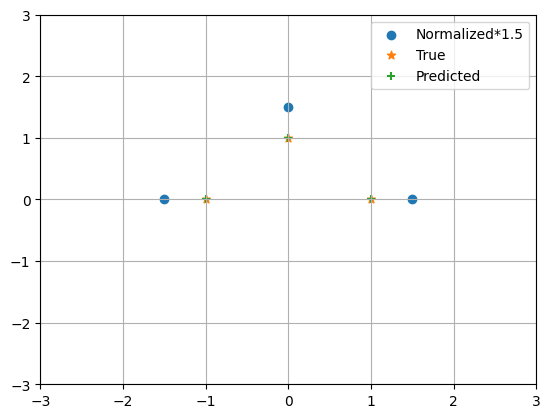

In [162]:

plt.scatter(normalized_points[:, 0]*1.5, normalized_points[:, 1]*1.5, label="Normalized*1.5")
plt.scatter(np.cos(true_angles), np.sin(true_angles), marker="*", label="True")
plt.scatter(np.cos(detector.azimuth_recon), np.sin(detector.azimuth_recon), marker="+", label="Predicted")
plt.legend()
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid()

## Error metrics

In [51]:
source_positions

array([[ 5.,  0.],
       [ 3., 10.],
       [-9.,  0.]])

In [174]:
# Generation strategy

def sources_uniform(num, amplitude=6):
    doas = np.random.random(num)*2*np.pi
    return np.stack([np.cos(doas), np.sin(doas)], axis=1)*amplitude

def _fixed_spread_doas(num, spread_deg):
    # First offset can be at most at the spread angle
    spread_rad = np.deg2rad(spread_deg)
    if spread_rad * num > 2*np.pi:
        raise ValueError(f"{num} * {spread_deg} > 360!!")
    offset = np.random.random()*(2*np.pi - spread_rad*num)
    return [offset + i*spread_rad for i in range(num)]
def fixed_spread(num, spread_deg, amplitude=6):
    doas = _fixed_spread_doas(num, spread_deg)
    return np.stack([np.cos(doas), np.sin(doas)], axis=1)*amplitude


In [163]:

from tqdm import tqdm
import itertools

def run_simulations(position_generator, simulations=100, time_slices=300, sources=N_sources):

    errors = []
    predictions = []
    grounds = []
    grounds_pos = []

    for _ in tqdm(range(simulations)):
        # Generate
        
        source_positions = position_generator(sources)
        mic_signals = generate_mic_signals(mic_positions, source_positions, different_exhausts, verbose=False)
        mic_time_slices = []

        for mic_i, signal in enumerate(mic_signals):
            mic_time_slices.append(list())
            for start, stop in overlapping_slices(
                nfft, nfft//2, len(signal)
            ):
                mic_time_slices[mic_i].append(signal[start:stop])


        observations = [np.array(mic_time_slices[mic_id])[:time_slices, :] for mic_id in range(N_mics)]
        observations_rfft = np.array([
            np.array([scipy.fft.rfft(_slice) for _slice in slices]).T
            for slices in observations
        ])
        # Detect
        detector = SRP(mic_positions.T, fs, nfft, speed_of_sound, N_sources, "far")
        detector.locate_sources(observations_rfft, freq_range=[100, 4000])
        predicted_doas = np.rad2deg(detector.azimuth_recon)
        normalized_points = source_positions / np.linalg.norm(source_positions, axis=1, keepdims=True)
        real_doas = np.rad2deg(np.arctan2(normalized_points[:, 1], normalized_points[:, 0])) % 360

        # Metric calculation
        min_norm = 1e3
        best_pred = None
        for permutation in list(itertools.permutations(list(range(len(source_positions))))):
            new_norm = np.linalg.norm(real_doas - predicted_doas[list(permutation)])
            min_norm = min(new_norm, min_norm)
            if min_norm == new_norm:
                best_pred = predicted_doas[list(permutation)]
        errors.append(min_norm)
        predictions.append(best_pred)
        grounds.append(real_doas)
        grounds_pos.append(source_positions)
    return {
        "errors": errors, 
        "predictions": predictions, 
        "grounds": grounds, 
        "grounds_pos": grounds_pos,
        "mean_error": np.mean(errors),
        "std_error": np.std(errors)
    }

In [164]:
results = run_simulations(sources_uniform, simulations=100, time_slices=300, sources=N_sources)

100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


In [165]:
results["mean_error"], results["std_error"]

(np.float64(174.3203594508808), np.float64(75.28664834633288))

In [78]:
results["predictions"][12], results["grounds"][12]

(array([113., 292., 206.]), array([ 83.53348778, 201.39792812, 114.17582444]))

In [79]:
from functools import partial 

results =  []
for spread in np.linspace(10, 120, 12):
    results.append(run_simulations(partial(fixed_spread, spread_deg=spread), simulations=100, time_slices=300, sources=N_sources))

100%|██████████| 100/100 [00:13<00:00,  7.39it/s]


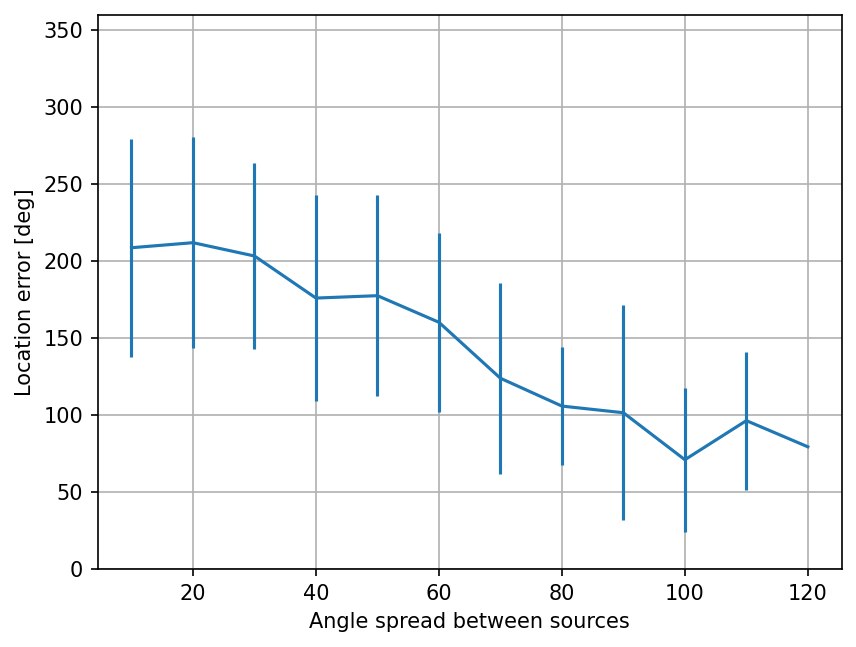

In [80]:

plt.figure(dpi=150, facecolor="white")
plt.errorbar(np.linspace(10, 120, 12), [result["mean_error"] for result in results], [result["std_error"] for result in results])
plt.xlabel("Angle spread between sources")
plt.ylabel("Location error [deg]")
plt.ylim(0, 360)
plt.grid()

100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


Text(0, 0.5, 'Location error [deg]')

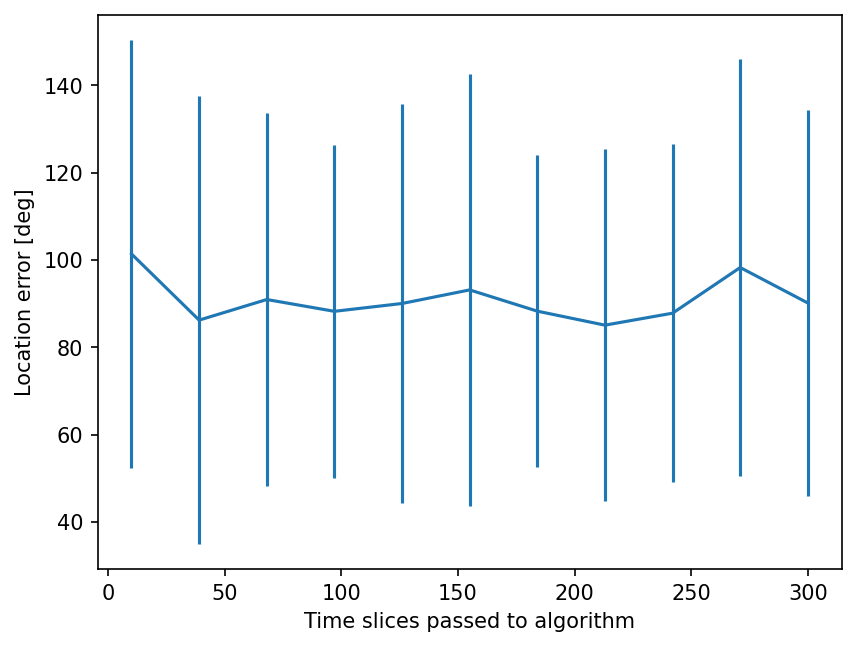

In [ ]:
from functools import partial 

results =  []
sweep = np.linspace(10, 300, 11)
for time_slices in sweep:
    results.append(run_simulations(partial(fixed_spread, spread_deg=90), simulations=100, time_slices=int(time_slices), sources=N_sources))

plt.figure(dpi=150, facecolor="white")
plt.errorbar(sweep, [result["mean_error"] for result in results], [result["std_error"] for result in results])
plt.xlabel("Time slices passed to algorithm")
plt.ylabel("Location error [deg]")

100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


Text(0, 0.5, 'Location error [deg]')

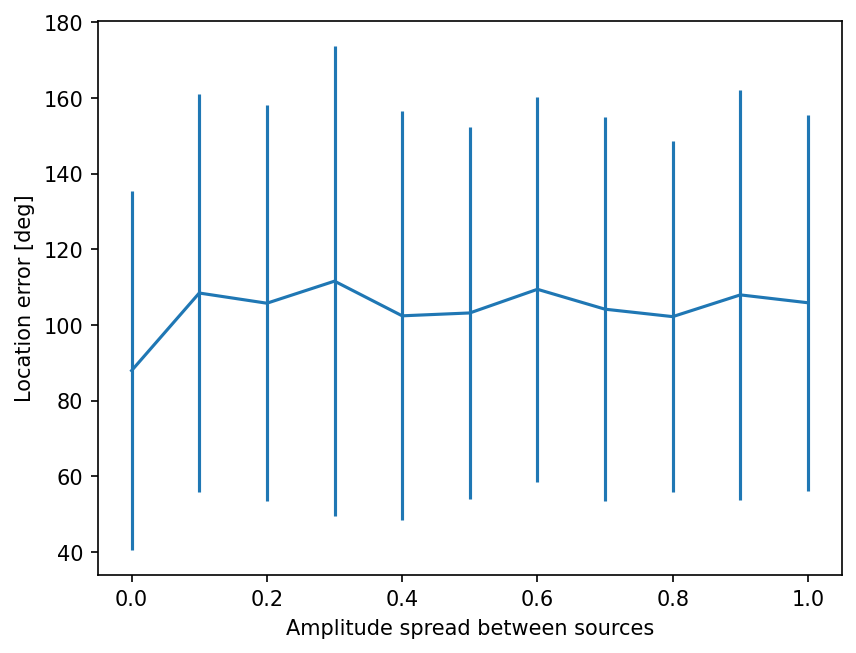

In [ ]:
from functools import partial 

results =  []
sweep = np.linspace(0, 1, 11)
def random_amplitude(n, ratio):
    return np.random.random(n) * ratio + 1 - ratio/2
def fixed_spread_with_random_amplitude(n, ratio, spread_deg):
    return fixed_spread(n, spread_deg=spread_deg) * random_amplitude(n, ratio).reshape(n, 1)
for ratio in sweep:
    results.append(run_simulations(partial(fixed_spread_with_random_amplitude, spread_deg=90, ratio=ratio), simulations=100, time_slices=100, sources=N_sources))

plt.figure(dpi=150, facecolor="white")
plt.errorbar(sweep, [result["mean_error"] for result in results], [result["std_error"] for result in results])
plt.xlabel("Amplitude spread between sources")
plt.ylabel("Location error [deg]")

## Using sound generation from the library

============ Using anechoic: True ==================
CSSM
  True azimuth:  61.0
  Recovered azimuth: [61.] degrees
  Error: [0.] degrees
FRIDA
  True azimuth:  61.0
  Recovered azimuth: [61.18435827] degrees
  Error: [0.18435827] degrees
MUSIC
  True azimuth:  61.0
  Recovered azimuth: [61.] degrees
  Error: [0.] degrees
NormMUSIC
  True azimuth:  61.0
  Recovered azimuth: [61.] degrees
  Error: [0.] degrees
SRP
  True azimuth:  61.0
  Recovered azimuth: [61.] degrees
  Error: [0.] degrees
TOPS
  True azimuth:  61.0
  Recovered azimuth: [61.] degrees
  Error: [0.] degrees
WAVES
  True azimuth:  61.0
  Recovered azimuth: [61.] degrees
  Error: [0.] degrees


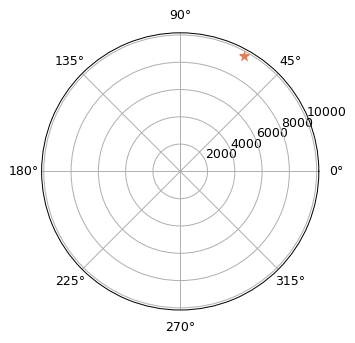

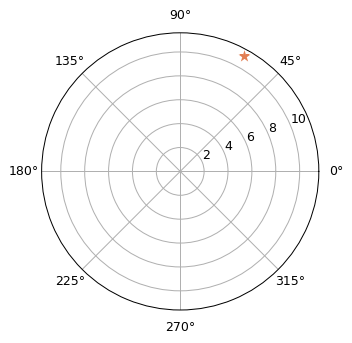

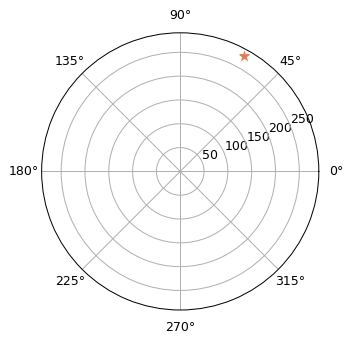

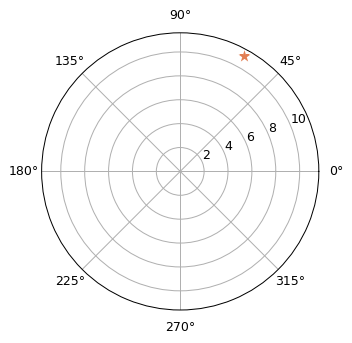

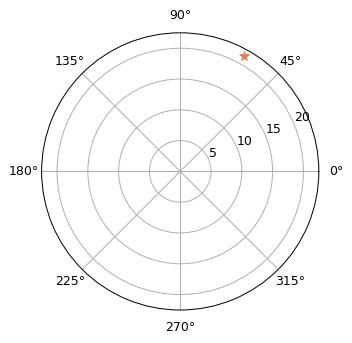

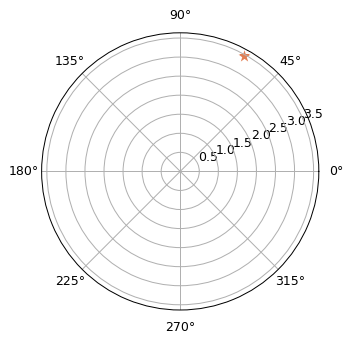

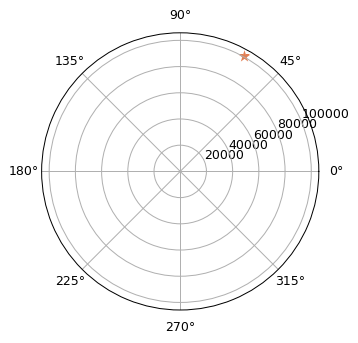

In [8]:
from scipy.signal import fftconvolve

import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

# Location of original source
azimuth = 61.0 / 180.0 * np.pi  # 60 degrees
distance = 3.0  # 3 meters
dim = 2  # dimensions (2 or 3)
room_dim = np.r_[10.0, 10.0]

# Use AnechoicRoom or ShoeBox implementation. The results are equivalent because max_order=0 for both.
# The plots change a little because in one case there are no walls.
use_anechoic_class = True

print("============ Using anechoic: {} ==================".format(use_anechoic_class))

#######################
# algorithms parameters
SNR = 0.0  # signal-to-noise ratio
c = 343.0  # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_bins = np.arange(5, 60)  # FFT bins to use for estimation

# compute the noise variance
sigma2 = 10 ** (-SNR / 10) / (4.0 * np.pi * distance) ** 2

# Create an anechoic room
if use_anechoic_class:
    aroom = pra.AnechoicRoom(dim, fs=fs, sigma2_awgn=sigma2)
else:
    aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# add the source
source_location = room_dim / 2 + distance * np.r_[np.cos(azimuth), np.sin(azimuth)]
source_signal = np.random.randn((nfft // 2 + 1) * nfft)
aroom.add_source(source_location, signal=source_signal)

# We use a circular array with radius 15 cm # and 12 microphones
R = pra.circular_2D_array(room_dim / 2, 12, 0.0, 0.15)
aroom.add_microphone_array(pra.MicrophoneArray(R, fs=aroom.fs))

# run the simulation
aroom.simulate()

################################
# Compute the STFT frames needed
X = np.array(
    [
        pra.transform.stft.analysis(signal, nfft, nfft // 2).T
        for signal in aroom.mic_array.signals
    ]
)

##############################################
# Now we can test all the algorithms available
algo_names = sorted(pra.doa.algorithms.keys())

for algo_name in algo_names:
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](R, fs, nfft, c=c, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_bins=freq_bins)
    try:
        doa.polar_plt_dirac()
        plt.title(algo_name)
    except ValueError:
        pass

    # doa.azimuth_recon contains the reconstructed location of the source
    print(algo_name)
    print("  True azimuth: ", np.rad2deg(azimuth))
    print("  Recovered azimuth:", doa.azimuth_recon / np.pi * 180.0, "degrees")
    print("  Error:", circ_dist(azimuth, doa.azimuth_recon) / np.pi * 180.0, "degrees")

plt.show()

In [128]:
aroom.mic_array.signals

array([[ 0.0461096 , -0.01145389,  0.06178546, ...,  0.01453546,
         0.00648285, -0.00521607],
       [ 0.01709959,  0.04085832, -0.02906702, ...,  0.03560266,
        -0.04486259, -0.01746119],
       [ 0.00335935,  0.00642384,  0.02635024, ...,  0.02128513,
         0.04334094, -0.02021099],
       ...,
       [-0.03815713, -0.04271956, -0.03395098, ..., -0.00771853,
        -0.0117671 ,  0.04777799],
       [ 0.04188675,  0.03610062,  0.03626526, ...,  0.01831108,
         0.04898529, -0.01775216],
       [ 0.0214787 ,  0.02090593, -0.05054285, ..., -0.0485285 ,
        -0.00318711, -0.04216955]])

## Error measuring when using library's detector

In [81]:
sources_uniform(3)

array([[-5.99200794, -0.30958168],
       [ 0.18726788,  5.99707685],
       [-2.61062625, -5.40228013]])

In [127]:
np.array(different_exhausts).shape

(3, 441000)

In [201]:
import scipy.signal
# Location of original source
azimuths = np.deg2rad([30, 120])

def run_simulation(azimuths_list):
    n_sources = len(azimuths_list[0])
    distance = 3.0  # 3 meters
    dim = 2  # dimensions (2 or 3)
    room_dim = np.r_[10.0, 10.0]

    #######################
    # algorithms parameters
    SNR = 0.0  # signal-to-noise ratio
    c = 343.0  # speed of sound
    fs = 16000  # sampling frequency
    nfft = 256  # FFT size
    freq_bins = np.arange(5, 60)  # FFT bins to use for estimation

    # compute the noise variance
    sigma2 = 10 ** (-SNR / 10) / (4.0 * np.pi * distance) ** 2

    
    
    t = np.linspace(0, 1, num=int(fs*1))
    source_signals = np.array([
        #(np.sin(t*j*400*2*np.pi)).astype(np.float32)
        (scipy.signal.sawtooth(t*j*400*2*np.pi)).astype(np.float32)
        for j in range(1, n_sources+1)
    ])
    # We use a circular array with radius 15 cm # and 12 microphones
    R = pra.circular_2D_array(room_dim / 2, 8, 0.0, 0.15)
    results_by_algorithm = {}
    for azimuths in azimuths_list:
        aroom = pra.AnechoicRoom(dim, fs=fs, sigma2_awgn=sigma2)
        aroom.add_microphone_array(pra.MicrophoneArray(R, fs=aroom.fs))
        source_locations = room_dim / 2 + distance*np.array([np.cos(azimuths), np.sin(azimuths)]).T
        for signal_i in range(n_sources):
            location, signal = source_locations[signal_i], source_signals[:, signal_i]
            aroom.add_source(location, signal=signal)

        # run the simulation
        aroom.simulate()

        ################################
        # Compute the STFT frames needed
        X = np.array(
            [
                pra.transform.stft.analysis(signal, nfft, nfft // 2).T
                for signal in aroom.mic_array.signals
            ]
        )

        ##############################################
        # Now we can test all the algorithms available
        algo_names = sorted(pra.doa.algorithms.keys())

        
        for algo_name in algo_names:
            # Construct the new DOA object
            # the max_four parameter is necessary for FRIDA only
            doa = pra.doa.algorithms[algo_name](R, fs, nfft, c=c, max_four=4, num_src=len(azimuths))

            if algo_name not in results_by_algorithm:
                results_by_algorithm[algo_name] = {
                    "errors": [],
                    "grounds": [],
                    "predictions": [],
                }
            # this call here perform localization on the frames in X
            if algo_name == "FRIDA":
                continue
            doa.locate_sources(X, freq_bins=freq_bins)
            grnds = np.sort(np.rad2deg(doa.azimuth_recon))
            preds = np.sort(np.rad2deg(azimuths))
            try:
                results_by_algorithm[algo_name]["errors"].append(np.linalg.norm(preds-grnds))
            except ValueError:
                print(f"Error using algorithm {algo_name}")
                print("Preds", preds)
                print("Grnds", grnds)
                continue
            results_by_algorithm[algo_name]["grounds"].append(grnds)
            results_by_algorithm[algo_name]["predictions"].append(preds)
    return results_by_algorithm


In [210]:
total_results = {}
spreads = [30, 60, 90, 120]
for spread in spreads:
    results = run_simulation([np.array(_fixed_spread_doas(3, spread)).tolist() for _ in range(100)])
    if not len(total_results):
        total_results = {k:list() for k in results}
    for algo_name in results: 
        total_results[algo_name].append(np.round(np.mean(results[algo_name]["errors"]),2))


Error using algorithm WAVES
Preds [ 69.2029177  99.2029177 129.2029177]
Grnds [ 32. 199.]
Error using algorithm WAVES
Preds [109.61502356 139.61502356 169.61502356]
Grnds [134. 307.]


/home/joaquintz/res/thebird/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joaquintz/res/thebird/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error using algorithm WAVES
Preds [ 62.80959278 152.80959278 242.80959278]
Grnds [172. 297.]
Error using algorithm CSSM
Preds [  0. 120. 240.]
Grnds [115. 353.]
Error using algorithm CSSM
Preds [  0. 120. 240.]
Grnds [ 58. 252.]
Error using algorithm WAVES
Preds [  0. 120. 240.]
Grnds [ 63. 251.]
Error using algorithm CSSM
Preds [  0. 120. 240.]
Grnds [ 14. 225.]
Error using algorithm WAVES
Preds [  0. 120. 240.]
Grnds [ 23. 289.]
Error using algorithm CSSM
Preds [  0. 120. 240.]
Grnds [163. 334.]
Error using algorithm WAVES
Preds [  0. 120. 240.]
Grnds [ 93. 302.]


(0.0, 360.0)

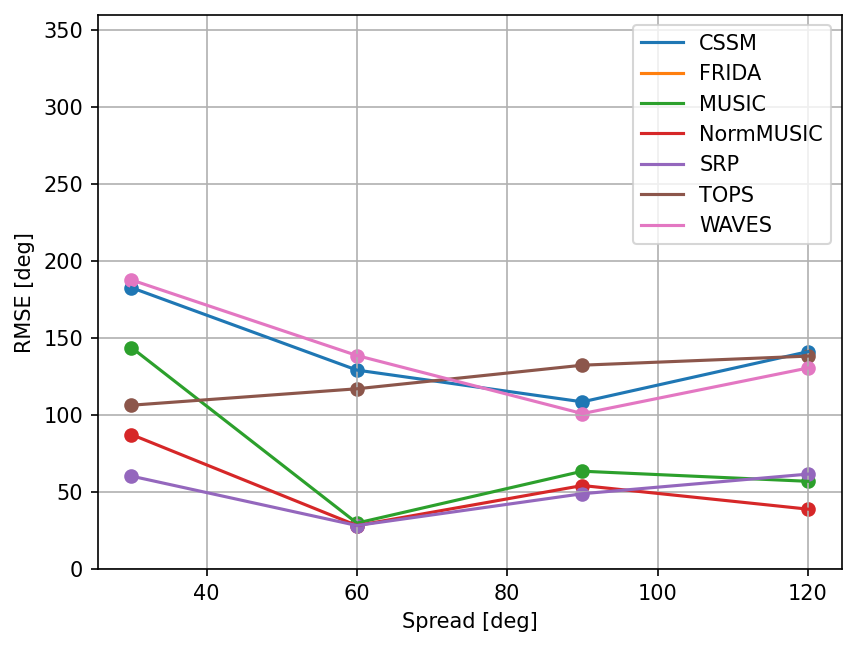

In [213]:
plt.figure(dpi=150, facecolor="white")
for algo, values in total_results.items():
    plt.plot(spreads, values, label=algo)
    plt.scatter(spreads, values)
plt.legend()
plt.xlabel("Spread [deg]")
plt.ylabel("RMSE [deg]")
plt.grid()
plt.ylim(0, 360)


CSSM
	Avg error: 101.97
	Std error: 67.09
FRIDA
	Avg error: nan
	Std error: nan
MUSIC
	Avg error: 66.96
	Std error: 60.45
NormMUSIC
	Avg error: 61.79
	Std error: 52.25
SRP
	Avg error: 54.27
	Std error: 52.87
TOPS
	Avg error: 125.68
	Std error: 68.53
WAVES
	Avg error: 91.62
	Std error: 63.9


In [205]:
for algo_name in results: 
    print(algo_name)
    print(f"\tAvg error:", np.round(np.mean(results[algo_name]["errors"]),2))
    print(f"\tStd error:", np.round(np.std(results[algo_name]["errors"]),2))

CSSM
	Avg error: 183.61
	Std error: 53.53
FRIDA
	Avg error: nan
	Std error: nan
MUSIC
	Avg error: 150.82
	Std error: 80.76
NormMUSIC
	Avg error: 76.14
	Std error: 85.65
SRP
	Avg error: 70.97
	Std error: 79.49
TOPS
	Avg error: 113.54
	Std error: 72.9
WAVES
	Avg error: 177.56
	Std error: 54.1


/home/joaquintz/res/thebird/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joaquintz/res/thebird/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/joaquintz/res/thebird/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/joaquintz/res/thebird/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/joaquintz/res/thebird/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
